In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import random

In [2]:
def generateNormalVariables(n, normalVar, mu_mean=0, mu_stdev=1, sd_mean=0, sd_stdev=1):

    X = {}

    for j in range(normalVar):
        np.random.seed(seed = j)   #seed for distribution
        random.seed(j)   #seed for random number generator
        
        # The following two lines generate random mean and variance for each predictor from
        # from random normal distributions for each of the mean and standard deviation
        mu = np.random.normal(mu_mean, mu_stdev)
        sigma = abs(np.random.normal(sd_mean, sd_stdev))
        
        X[j] = np.random.normal(mu, sigma, n)
    return X

(array([  5.,  18.,  74., 193., 257., 250., 147.,  38.,  14.,   4.]),
 array([-0.64532212, -0.41714632, -0.18897052,  0.03920528,  0.26738108,
         0.49555687,  0.72373267,  0.95190847,  1.18008427,  1.40826006,
         1.63643586]),
 <a list of 10 Patch objects>)

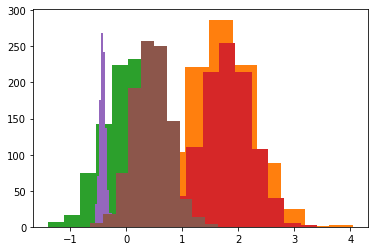

In [3]:
# Visualizing distribution of a few variables from generateNormalVariables (density plots would be better)
var_dict = generateNormalVariables(1000,10)
plt.hist(var_dict[0])
plt.hist(var_dict[1])
plt.hist(var_dict[4])
plt.hist(var_dict[3])
plt.hist(var_dict[2])
plt.hist(var_dict[5])

In [4]:
def generateCountVariables(n, countVar, pois_mean=10):
    X = {}
    
    for i in range(countVar):
        # Created alternative count variable generation method to generate counts from negative binomial distribution.
        # Negative binomial is basically the number of trials to obtain fixed "num" successes when the success probability
        # is p (whereas regular binomial is number of successes for fixed number of trials with success probability p).
        np.random.seed(seed = i)   #seed for distribution
        random.seed(i)   #seed for random number generator
        
        # The following two lines generate random parameters for negative binomial distribution to draw counts from
        # Poisson seemed like a natural choice for "num" successes, and uniform seemed like a natural choice for 
        # generating success probabilities.
        num = np.random.poisson(pois_mean) + 1 #add one to ensure num > 0
        p = np.random.uniform(low=0.1,high=0.9) # Placed some limits on p to avoid insanely high counts     
        X[i] = np.random.negative_binomial(num, p, n)
    return X

(array([ 86., 129., 341., 150., 106., 109.,  33.,  38.,   3.,   5.]),
 array([ 0. ,  1.4,  2.8,  4.2,  5.6,  7. ,  8.4,  9.8, 11.2, 12.6, 14. ]),
 <a list of 10 Patch objects>)

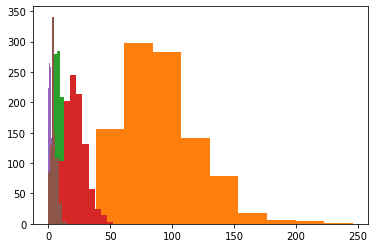

In [5]:
# Visualizing distribution of a few variables from generateCountVariables (density plots would be better)
# Get some decent variability in range of count variable distributions with pois_mean=10
var_dict = generateCountVariables(1000,10,pois_mean=10)
plt.hist(var_dict[0])
plt.hist(var_dict[1])
plt.hist(var_dict[2])
plt.hist(var_dict[3])
plt.hist(var_dict[4])
plt.hist(var_dict[5])

In [6]:
def generateCategoricalVariables(n, catVar, pois_mean = 5):
    temp = {}
    
    for i in range(catVar):
        ### We follow the same principle as count variables. 
        ### But, finally we convert the categorical variables to dummy variables
        ### Note: We use **** k-1 dummy variables **** for k categories (kth variable is baseline)
        
        np.random.seed(seed = i)   #seed for distribution
        random.seed(i)   #seed for random number generator
        
        # Made it so that number of categories is generated randomly (don't have to supply vector)
        noOfCat = np.random.poisson(pois_mean) + 2 #add two to ensure numOfCat > 1
        categories = np.arange(noOfCat)
        population = np.repeat(categories , n)
        random.shuffle(population)
        temp[i] = random.sample(list(population), n)
    #X = pd.DataFrame.from_dict(temp)
    # NOTE: Decided to keep as non-dummy coded dictionary to remain consistent with other variable
    # generation codes
    ### Changed drop_first to True; otherwise we have multicollinearity
    ###X = pd.get_dummies(X,columns=X.columns,drop_first=True)
    return temp

In [7]:
# Visualizing distribution of a few variables from generateCategoricalVariables (density plots would be better)
var_dict = generateCategoricalVariables(10000,10,pois_mean=3)
max(var_dict[9])
#plt.hist(var_dict[0])
#plt.hist(var_dict[1])
#plt.hist(var_dict[2])
#plt.hist(var_dict[3])
#plt.hist(var_dict[4])
#plt.hist(var_dict[5])

1

In [30]:
# RANDOM INTERCEPT SHOULD BE PART OF BETAS; FOR DATA JUST NEED COLUMN OF ONES

#def generateRandomIntercept(n):
#    ### For each observation (X) we generate an intercept
#    np.random.seed(seed = 123)
#    intercept =  np.random.normal(0, 1, n)
#    return intercept

In [31]:
### The following function also needs some cleaning up. 
### It is just generating all types of variables and putting them together
### We also define how many observations, how many of each variable we need to generate here

def generateX():
    
    # Enter Number of Observations
    n = int(input('Enter number of observations:'))
    intercept = np.repeat(1,n) # Create n 1's for intercept column
    X = pd.DataFrame(intercept.reshape(n,1))
    
    # Enter Number of Continuous Variables
    normalVar = int(input('Enter number of continuous variables (normally distributed):'))
    if normalVar != 0:
    #normalVar = 5
        Xnorm = generateNormalVariables(n, normalVar)
        Xnorm = pd.DataFrame.from_dict(Xnorm)
        X = pd.concat([X, Xnorm],ignore_index=True,axis=1)
    
    # Enter Number of Ordinal Variables
    countVar = int(input('Enter number of count variables:'))
    if countVar != 0:
    #maxCount = input('Enter the numbers separated by space: each number correspond to maxCount:')
    #maxCount = list(map(int, maxCount.split()))
    #countVar = 1
    #maxCount = [4]
        Xcnt = generateCountVariables(n, countVar)#Make sure countVar = len(maxCount)
        Xcnt = pd.DataFrame.from_dict(Xcnt)
        X = pd.concat([X, Xcnt],ignore_index=True,axis=1)

    # Enter Number of Nominal Variables
    catVar = int(input('Enter number of categorical variables:'))
    if catVar != 0:
    #catNumber = input('Enter the numbers separated by space: each number correspond to number of categories:')
    #catNumber = list(map(int, catNumber.split()))
    #catVar = 1
    #catNumber = [2]
        Xcat = generateCategoricalVariables(n, catVar)#Make sure catvar = len(catNumber)
        Xcat = pd.DataFrame.from_dict(Xcat)
        Xcat = pd.get_dummies(Xcat, columns=Xcat.columns, drop_first=True)
        # Changed drop_first to True; otherwise we have multicollinearity
        X = pd.concat([X, Xcat],ignore_index=True,axis=1)
    
    return X

In [32]:
generateX()

Enter number of observations:1000
Enter number of continuous variables (normally distributed):1
Enter number of count variables:1
Enter number of categorical variables:1


,0,1,2,3,4,5,6,7,8,9,10,11,12
0,1,2.155701,8,0,0,0,0,0,0,0,1,0,0
1,1,2.660762,11,0,1,0,0,0,0,0,0,0,0
2,1,2.511369,7,0,0,0,0,0,0,0,0,1,0
3,1,1.372988,7,0,0,0,0,0,0,0,1,0,0
4,1,2.144237,6,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,1,1.801744,4,0,0,0,0,0,0,0,1,0,0
996,1,1.304828,5,0,0,0,1,0,0,0,0,0,0
997,1,1.620750,11,0,0,0,0,0,0,0,0,1,0
998,1,1.986525,7,0,0,0,0,0,0,0,0,0,1


In [81]:
### This generates q (p+1) random standard normally distributed betas (including random intercept)
### This function needs work
### Either we have to find beta's, which work for all three distributions
### Or we can generate different sets of beta's for different distribution
### I think, same beta's would be better for comparison


def generateRandomBeta(q):
    beta = {}
    for j in range(q):
        random.seed(j)#seed for random number generator
        beta[j] = np.random.normal(0,0.1)
    
    beta = pd.DataFrame(list(beta.items()))
    beta = beta.drop([0],axis=1)
    
    return beta

In [82]:
#a = generateX()
#b = generateRandomBeta(a.shape[1])
#m = a.dot(b)

In [83]:
#for i in np.squeeze(m.values): print(i)

In [84]:
def sigmoid(z):
    return 1/(1+np.exp(-z))

In [91]:
### This function generates response variable (y)
### As input with X matrix n x (p+1), and beta vector (p+1) x 1
### We also provide the name of the distribution as a quoted string

def generateResponseVariable(X, beta, dist):
    if dist == 'bernoulli':
        meanValues = sigmoid(X.dot(beta)) 
    elif dist == 'poisson':
        meanValues = np.exp(X.dot(beta))
    elif dist == 'exponential':
        meanValues = 1/(X.dot(beta))
    else:
        print('please spell check distribution name, all lowercase: bernoulli, poisson or exponential')
        
    y = []
    
    np.random.seed(123)
    for eachMean in np.squeeze(meanValues.values):
        if dist == 'bernoulli':
            randomPrediction = np.random.binomial(1,eachMean)
        elif dist == 'poisson':
            randomPrediction = np.random.poisson(eachMean)
        elif dist == 'exponential':
            randomPrediction = np.random.exponential(eachMean)
        y.append(randomPrediction)
        print(randomPrediction, eachMean)
    
    return y

In [92]:
### This little function is just commanding to generate X, beta and y
def generateData(dist):
    X = generateX()

    n,q = X.shape
    beta = generateRandomBeta(q)

    y = generateResponseVariable(X, beta, dist) ### dist means pass distribution name as string
    return X, beta, y

In [130]:
X, b, y = generateData('bernoulli')
print(b)
X.head()

Enter number of observations:10000
Enter number of continuous variables (normally distributed):200
Enter number of count variables:0
Enter number of categorical variables:0
0 0.10809801785080532
0 0.13560402025940177
1 0.6371001738391269
1 0.6557814274263939
1 0.492574698566562
0 0.06684726510349866
1 0.0659702166315931
1 0.3791889127734565
0 0.2699911068504182
1 0.7334717145743435
0 0.28469273777260223
1 0.3816734932398944
0 0.4569587503009823
1 0.6957753758509905
1 0.5736282076525253
0 0.1985759063166421
0 0.2229251595449972
1 0.5558176835875186
0 0.44093522341212577
1 0.6245192742949673
0 0.3141286852743556
0 0.8041251713636769
0 0.6348581541096104
1 0.8157674292831272
0 0.6902297750623825
1 0.579138757389285
1 0.9269266963167244
1 0.7485414517810515
1 0.8741267736934418
1 0.7919529687578176
1 0.6643829242785456
0 0.42951141148957056
1 0.8813064891408289
1 0.6021314660202384
1 0.5262827102272257
1 0.5475416427039494
0 0.3457689491196407
1 0.908588969325082
1 0.25293580352646367
1 0.

1 0.9399103927981237
1 0.5180943522623173
1 0.8428148530770218
1 0.41415566603231324
0 0.29671461320002973
0 0.8314093507635338
1 0.8505440617874575
1 0.2616056665863541
1 0.8562009156095081
1 0.8945835717458301
1 0.7763913794034619
0 0.8679443709848126
0 0.4623459458338915
0 0.788500984767029
1 0.8536461344919314
0 0.6071901961105982
0 0.5169877766477734
1 0.5528414649276883
1 0.600740775169211
1 0.9388400963615475
1 0.7366655696140606
1 0.7578986058478033
1 0.8878252958033777
0 0.1754605924201533
1 0.5365525029377354
1 0.50275516402857
1 0.27686047433187944
0 0.5786693154024918
1 0.931280491111527
1 0.9662031525232211
1 0.6942317471553606
1 0.7622321455091253
1 0.6568602522612863
1 0.7638384314249671
1 0.9614541538001004
1 0.8293225475764967
1 0.9672152414115379
1 0.6204534970969653
1 0.8287389039080688
1 0.7292004713478569
1 0.5402194406057698
0 0.3579050052927575
1 0.43319988825282574
0 0.6637688182925553
1 0.5287832767719074
0 0.5642421310854274
1 0.9694525702287847
1 0.7203546482

1 0.9557441300666516
1 0.7392734032200559
1 0.8094188597047639
1 0.39619555387082045
1 0.7318089152352507
0 0.5639494002922965
1 0.7431251766427879
0 0.24603230704881782
1 0.6182246194277994
1 0.9673969893908106
1 0.8265875331466658
0 0.3805883712042993
0 0.45520429174868415
0 0.3141143975447186
1 0.6373648041189769
1 0.7450135711982612
1 0.8585418514246543
0 0.17158433884049507
0 0.25228009561228626
0 0.6338265789800713
0 0.6968770363074124
1 0.3587574819673522
1 0.4986361216709046
0 0.5056489719500658
1 0.22511681021332697
0 0.7490123630022053
1 0.7798203825230878
1 0.45915546359848025
1 0.6023707030758415
1 0.6888438275320744
1 0.4549272874720543
1 0.8714218788137005
1 0.976107580550695
1 0.8312837903889384
1 0.5290448624898281
1 0.6083253143188054
1 0.6044955028803694
1 0.8749681657988132
0 0.5059614822276087
0 0.848304595503713
1 0.6066620602433757
1 0.948661852378436
0 0.4364383572913986
0 0.12963807931713683
0 0.3859800215260858
1 0.9727748159481155
1 0.9337340451015883
0 0.2490

1 0.9612560105853577
1 0.8236494744400638
0 0.0325628509189417
1 0.9216964871642389
1 0.9285838233249677
0 0.577512494385332
1 0.686500737136673
1 0.8514391512801567
1 0.3795787411859286
0 0.08583295462859919
1 0.6593081636510953
1 0.603884303692901
0 0.3486356319496084
1 0.7434740400067147
1 0.2954565710899705
1 0.28394800625917443
0 0.6826403559116377
1 0.5797626706841472
0 0.07522348201152797
1 0.7986684378750787
1 0.8769402095903831
1 0.908050547468411
1 0.341577360656964
1 0.45981867701351803
0 0.5269207860758235
1 0.4438710054420649
1 0.9643822055101977
0 0.73048189425152
1 0.6643207439673239
0 0.21522870424988502
1 0.5799955098560694
1 0.8649299550148178
1 0.2031703431154373
0 0.1011107830329389
0 0.7696691071797231
1 0.8604321210511638
1 0.32658921572093236
0 0.6190515150848829
1 0.22254842246147655
1 0.799720335181909
1 0.656845477636381
0 0.8050149253041978
1 0.6511759475647465
1 0.7943354670634414
1 0.9152425802248959
0 0.5892481497463817
1 0.9833909894304083
0 0.69417439409

1 0.44869172388811385
0 0.40176363789014446
0 0.27516038395897224
1 0.4912746487180522
1 0.7347167191138698
0 0.2920652978115571
0 0.815444884089915
1 0.7446838227218634
1 0.5178655257199729
1 0.5183890273345795
0 0.19357433104829322
0 0.41527464134038466
1 0.9534364076655073
0 0.8383757129936975
0 0.4869490405773942
0 0.49552946755157734
0 0.6139213718633342
0 0.7198574160374234
1 0.551991761765162
0 0.7100694596300342
1 0.1762144896770287
1 0.5757672138855889
1 0.8355172200503004
1 0.2039173073661288
1 0.5486136430452901
1 0.9675208868055827
1 0.554614155223787
0 0.34496332174800964
1 0.9111623011188642
0 0.06378484078059785
0 0.7077781973102871
0 0.04626732512644567
0 0.2437431382085829
1 0.20896393420185924
1 0.3219042972797183
1 0.756853615683876
1 0.08344959792751779
1 0.7604237179839333
1 0.745919576742715
1 0.32884698555981834
1 0.6310332072132145
0 0.02525956827750519
1 0.943426743776705
1 0.5663692956766058
1 0.49189021653139764
1 0.8026388712067459
0 0.02569149774230418
1 0.

,0,1,2,3,4,5,6,7,8,9,...,191,192,193,194,195,196,197,198,199,200
0,1,2.155701,1.301233,-0.536955,1.830751,-0.447344,1.245497,-0.152991,1.705818,-2.033490,...,2.486049,-1.753123,0.249973,0.872514,4.024211,-1.568809,-3.826805,-0.055563,0.426454,1.845683
1,1,2.660762,0.967950,-0.324465,0.975196,0.397327,0.357818,-0.967225,1.880403,-1.421695,...,2.020524,-1.781307,-0.847356,1.482592,3.337213,2.086840,1.078637,0.734657,0.449889,0.513324
2,1,2.511369,2.153764,-0.517669,1.667546,-0.158569,0.477494,-2.124657,1.322937,-2.414917,...,1.146169,-1.383457,-0.790527,1.768178,1.959795,1.592673,0.940805,0.712571,0.453132,0.613671
3,1,1.372988,0.216364,-0.464120,1.633773,-0.741650,0.964823,0.353980,1.691488,2.721015,...,1.180589,-1.807248,-1.570600,2.863957,-1.165515,0.821972,3.603994,0.772329,0.149735,1.459337
4,1,2.144237,2.691745,-0.388462,1.752511,-0.273260,0.140390,0.509850,1.690111,1.976762,...,1.781353,-1.482904,-1.870724,0.191206,3.721580,2.566253,-0.561247,0.588596,0.650090,1.497857


In [131]:
np.mean(y)

0.5955

In [18]:
### Look at the poisson responses
### The dispersion is too high :(
### One reason that the X's and beta's need careful consideration
generateData('poisson')

Enter number of observations:5
0 1.8888888563301906e-08
125 143.73260331555142
0 2.4509411367799024e-07
289466 288836.245666733
0 4.265803164385503e-11


(          0         1         2         3         4         5  6  7  8
 0 -5.428153  0.668536  0.553898  0.840467  2.393134  0.035891  1  0  1
 1  4.986727  0.151650 -0.393576  1.694675  0.553478  0.244519  1  0  0
 2  1.414892  0.370919 -0.358160 -3.233860  0.090866 -0.449930  0  1  3
 3 -7.531474  0.849247 -0.588999  5.714737 -2.575844  0.334419  0  1  1
 4 -2.893001  0.707762  0.232324 -2.421666 -0.417833 -0.181777  1  0  3,      1
 0  1.0
 1  1.0
 2 -1.5
 3  2.0
 4 -2.5
 5  3.0
 6 -3.5
 7  4.0
 8 -4.5, [0, 125, 0, 289466, 0])

In [17]:
### All X.beta's have to be negative  :(
### One reason that the generation function of X and beta needs work
generateData('exponential')

Enter number of observations:5
0.04475053649569026 0.05622813149145228


ValueError: scale < 0

# Below are the individual functions, which I accumulated above. If you guys think the individual functions are better.....

In [83]:
# def generateBernoulliResponse(X, beta):
#     meanValues = sigmoid(X.dot(beta)) ### Applying mean function
#     meanValues = np.array([item for sublist in meanValues.values for item in sublist])
#     y = []
#     for eachMean in meanValues:
#         np.random.seed(int(round(eachMean)))
#         randomPrediction = np.random.binomial(1,eachMean) ### predict a random number using the mean
#         y.append(randomPrediction)
#         print(randomPrediction, eachMean)
#     return y

In [88]:
# def generatePoissonResponse(X, beta):
#     meanValues = np.exp(X.dot(beta)) ### Applying mean function
#     meanValues = np.array([item for sublist in meanValues.values for item in sublist])
#     y = []
#     for eachMean in meanValues:
#         np.random.seed(int(round(eachMean)))
#         randomPrediction = np.random.poisson(eachMean) ### predict a random number using the mean
#         y.append(randomPrediction)
#         print(randomPrediction, eachMean)
#     return y

In [ ]:
# def generateExponentialResponse(X, beta):
#     meanValues = -1/X.dot(beta) ### Applying mean function
#     meanValues = np.array([item for sublist in meanValues.values for item in sublist])
#     y = []
#     for eachMean in meanValues:
#         np.random.seed(int(round(eachMean)))
#         randomPrediction = np.random.exponential(eachMean) ### predict a random number using the mean
#         y.append(randomPrediction)
#         print(randomPrediction, eachMean)
#     return y

In [95]:
# def generateBernoulliData():
#     X = generateX()

#     n,p = X.shape
#     beta = generateRandomBeta(p)

#     y = generateBernoulliResponse(X, beta)
#     return X, beta, y

In [96]:
# def generatePoissonData():
#     X = generateX()

#     n,p = X.shape
#     beta = generateRandomBeta(p)

#     y = generatePoissonResponse(X, beta)
#     return X, beta, y

In [97]:
# def generateExponentialData():
#     X = generateX()

#     n,p = X.shape
#     beta = generateRandomBeta(p)

#     y = generateExponentialResponse(X, beta)
#     return X, beta, y